<a href="https://colab.research.google.com/github/Pranav2612000/course.fast.ai/blob/main/lesson2/General_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download packages and imports

In [1]:
!pip install duckduckgo_search
!pip install fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00


In [26]:
from duckduckgo_search import ddg_images
from time import sleep

from fastcore.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastdownload import download_url

## Configuration Variables

In [18]:
CONFIG = {
  "AUG_TRANSFORMS": True
}

CATEGORIES = ["batman", "superman", "shaktiman", "wonderwoman"]
SEARCH_TERMS = {}
SEARCH_TERMS = {
    "batman": ["batman potrait", "batman comic", "batman headshot"],
    "superman": ["superman potrait", "superman comic", "superman headshot"],
    "shaktiman": ["shaktiman potrait", "shaktiman comic", "shaktiman headshot"],
    "wonderwoman": ["wonderwoman potrait", "wonderwoman comic", "wonderwoman headshot"]
}

## Get Training Data

In [4]:
def search_images(term, max_images = 30):
  print(f"Searching for '{term}'")
  return L(ddg_images(term, max_results = max_images)).itemgot('image')

In [ ]:
SEARCH_TERMS["batman"]

['batman potrait', 'batman comic', 'batman headshot']

In [ ]:
!rm training_images -rf

In [5]:
path = Path('training_images')

for o in CATEGORIES:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)

  if SEARCH_TERMS and o in SEARCH_TERMS.keys():
    for term in SEARCH_TERMS[o]:
      download_images(dest, urls = search_images(term))
      sleep(10)
  else:
    download_images(dest, urls = search_images(o))
    sleep(10)

Searching for 'batman potrait'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


Searching for 'batman comic'
Searching for 'batman headshot'
Searching for 'superman potrait'
Searching for 'superman comic'
Searching for 'superman headshot'
Searching for 'shaktiman potrait'
Searching for 'shaktiman comic'
Searching for 'shaktiman headshot'
Searching for 'wonderwoman potrait'
Searching for 'wonderwoman comic'
Searching for 'wonderwoman headshot'


In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f'Removed {len(failed)} incorrectly downloaded images')

Removed 16 incorrectly downloaded images


## Training the model

In [35]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(192, method='squish')],
    batch_tfms = aug_transforms(mult=2) if ("AUG_TRANSFORMS" in CONFIG) and CONFIG["AUG_TRANSFORMS"] == True else None
).dataloaders(path, bs=32)

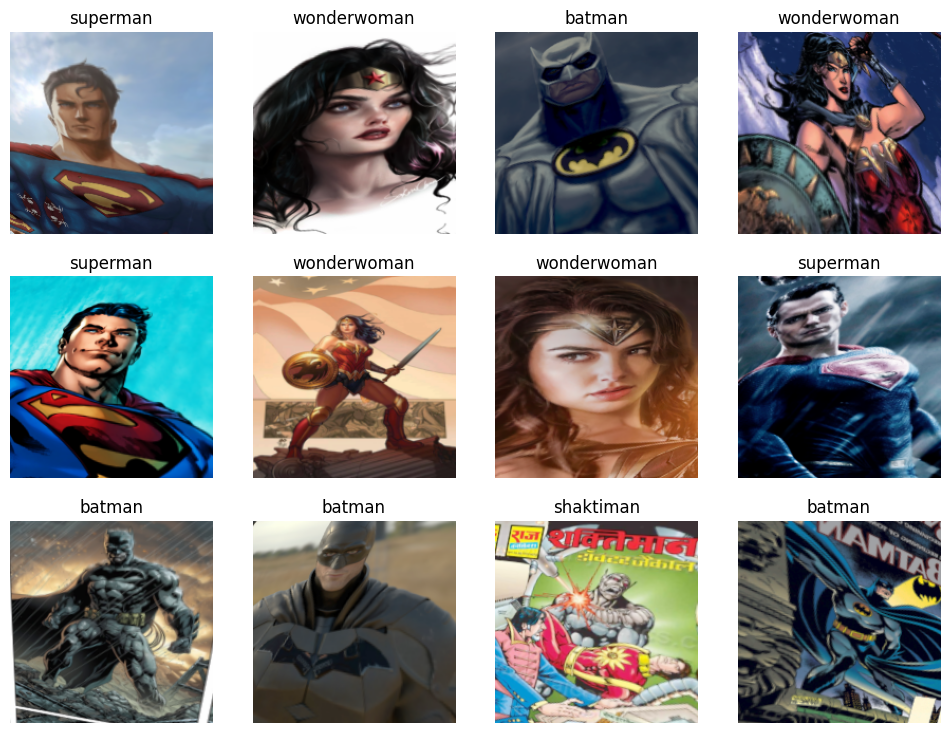

In [36]:
dls.show_batch(max_n = 12)

In [37]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Improving the Model [ Optional ]

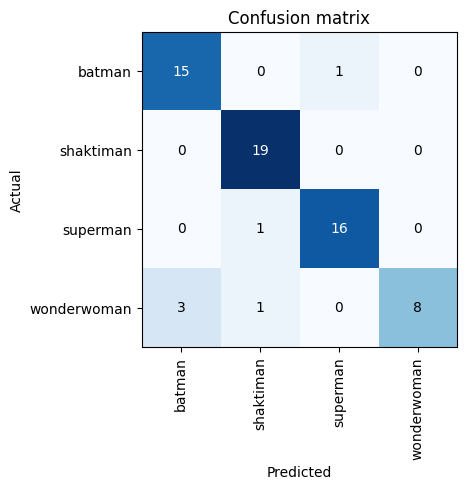

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

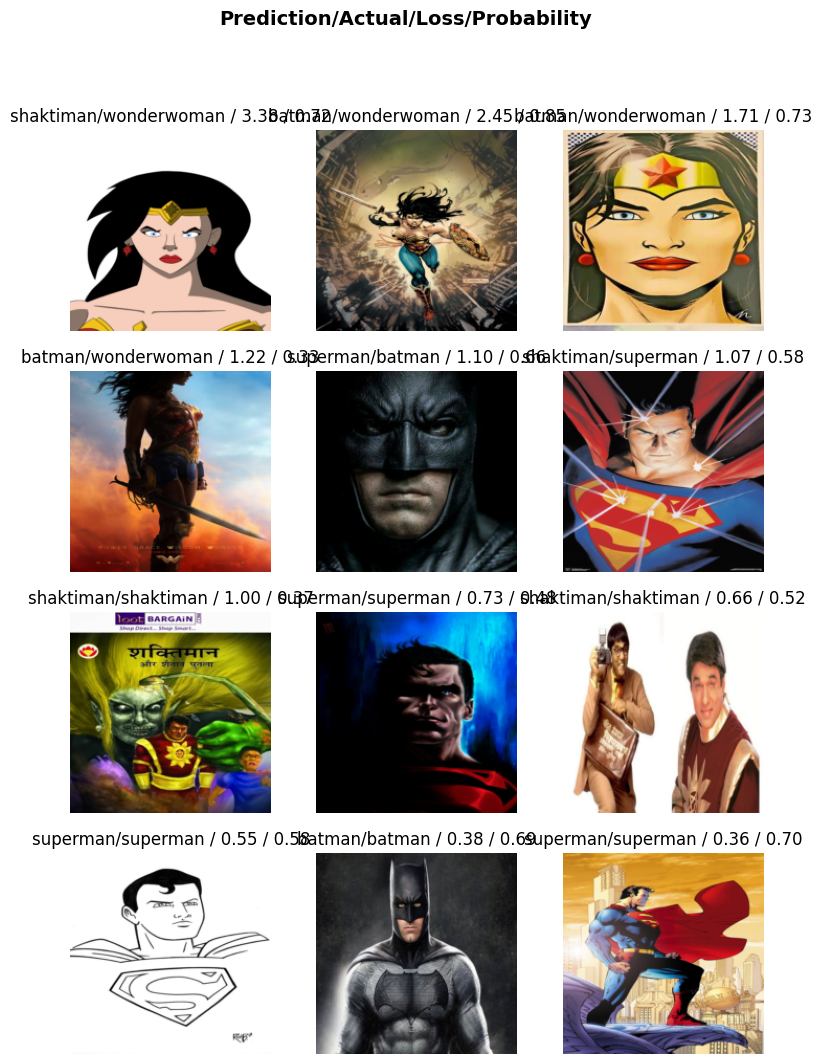

In [39]:
interp.plot_top_losses(12, nrows=4)

In [40]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [44]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [45]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Retrain the model now by following the steps in ( or re-running ) the "Train the model" section.

## Testing the model

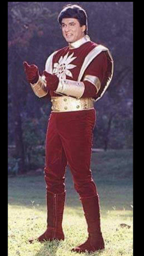

Category: shaktiman
Probability: 0.0003


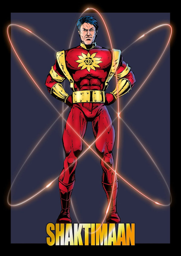

Category: shaktiman
Probability: 0.0005


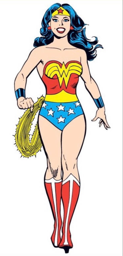

Category: shaktiman
Probability: 0.0483


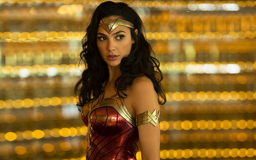

Category: wonderwoman
Probability: 0.0003


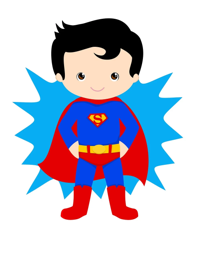

Category: shaktiman
Probability: 0.3996


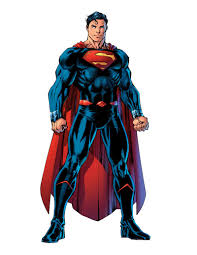

Category: shaktiman
Probability: 0.0389


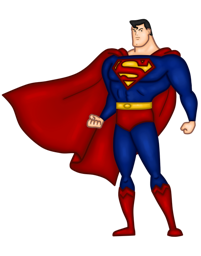

Category: superman
Probability: 0.0002
Error with image at index 7. Skipping...


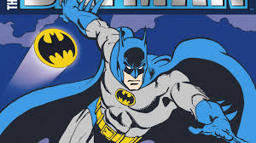

Category: batman
Probability: 0.9659


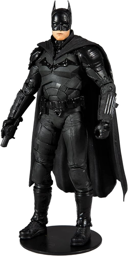

Category: batman
Probability: 0.9906


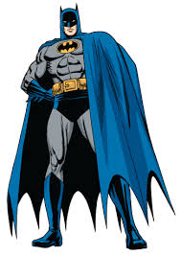

Category: batman
Probability: 0.6046


In [47]:
test_images = [
  "https://i.pinimg.com/736x/b1/18/2b/b1182b161f1ea918ef33b1fd7809d29a.jpg",
  "https://e0.pxfuel.com/wallpapers/327/340/desktop-wallpaper-more-collections-india-first-super-hero-shaktimaan.jpg",
  "https://i.pinimg.com/736x/0a/48/cb/0a48cb58b476501955f26a6883f643bd.jpg",
  "https://c4.wallpaperflare.com/wallpaper/273/83/721/movie-wonder-woman-1984-gal-gadot-wonder-woman-wallpaper-preview.jpg",
  "https://cdn.pixabay.com/photo/2017/07/06/18/48/superman-2478978_1280.jpg",
  "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ97NaymXS3EwQuJt-zU0R-UkeZBfDtnN8yDQ&usqp=CAU",
  "https://cdn.pixabay.com/photo/2020/07/11/04/41/superman-5392758_960_720.png",
  "https://www.reddit.com/media?url=https%3A%2F%2Fi.redd.it%2Fl7ul4xv9ns8b1.jpg",
  "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTPh1jzBiouwDrSq4NjXMFqYkd8t3gD-HwTtw&usqp=CAU",
  "https://m.media-amazon.com/images/I/61ektBcmOIL._AC_UF1000,1000_QL80_.jpg",
  "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRn6obW1Ko6iKzxGyayYLO4wPskcP_MLL8O1Q&usqp=CAU"
]

path = Path('testing_images')

path.mkdir(exist_ok=True, parents=True)

for [index, img_url] in enumerate(test_images):
  try:
    img_path = (path/(f'{index}.jpg'))
    download_url(img_url, img_path, show_progress=False)
    pred_cat, _, probs = learn.predict(PILImage.create(img_path))
    img = Image.open(img_path).to_thumb(256, 256)
    display(img)
    print(f'Category: {pred_cat}')
    print(f'Probability: {probs[0]:.4f}')
  except:
    print(f"Error with image at index {index}. Skipping...")

## Downloading the model

In [48]:
learn.export()